<h1>Dataset</h1>

<p>We will start by importing all requied libraries needed for this project.</p>

In [45]:
import os
import numpy as np
import pandas as pd
import polars as pl
import re

# Dimensionality Reduction
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap
import umap.plot

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Calculations
from scipy.stats import zscore
from sklearn.preprocessing import PowerTransformer

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
import shap.plots

<h3>Load Data</h3>
<p>Loading in both of our datasets from local files.</p>

In [3]:
demo_stats_df = pl.read_csv("Coursework Data/DemoStats.csv", null_values=None)
household_spend_df = pl.read_csv("Coursework Data/HouseholdSpend.csv", null_values=None)

<h3>Merging Data</h3>
<p>Next, we will combine these two datasets into one. We joined them on the "CODE" column, which is the common column between the two datasets.</p>

In [4]:
merged_df = demo_stats_df.join(
    household_spend_df,
    on=["CODE"],
    how="inner"
)

# Drop ID columns
merged_df = merged_df.drop(["GEO", "CODE"])

# Describe the data
merged_df.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,2.278714,1.770631,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,10.420684,8.140557,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

<p>The data is now merged. One thing that stands out to me is the extreme values at each end of the distribution. We will need to take a look at these values and see if they are valid or if they are outliers. We will do this later.</p>

<h1>Part 1: Clustering and Dimensionality Reduction</h1>

The first part of the coursework will focus
on identifying the characteristics of Canadian households, excluding their pension
behaviour. For this, do not include, in your clustering and dimensionality reduction models,
the target of the regression model in Part 2.

In [5]:
# Drop target variable
merged_df_clust = merged_df.drop("HSEP001S")

<h3>Null Values</h3>
<p>We will check for any null values in our dataset. If there are any, we will need to decide on how to handle them.</p>
<p>From doing a quick scan of the database, it seems null values are listed as string of "NA"s. We will need to convert these to actual null values.</p>

In [6]:
total_data_points = merged_df_clust.height
print(f"Total data points: {total_data_points}")
# Define a function to convert NA to None
def convert_na_to_nulls(df):
    return df.with_columns([
        pl.col(col).replace("NA", None).alias(col)
        if df.schema[col] == pl.Utf8 else pl.col(col)
        for col in df.columns
    ])

# Convert NA to None on both dataframes
merged_df_clust = convert_na_to_nulls(merged_df_clust)

# Get total nulls for each column
def count_na_strings(df):
    total_rows = df.height
    return {
        col: {
            "null_count": df[col].null_count(),
            "less than 1%": 1 / total_rows < 0.01,
        }
        for col in df.columns
        if df[col].null_count() > 0
    }

merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Total data points: 868970
Data Null Count: {'ECYPTAMED': {'null_count': 87459, 'less than 1%': True}, 'ECYPMAMED': {'null_count': 96444, 'less than 1%': True}, 'ECYPFAMED': {'null_count': 131837, 'less than 1%': True}, 'ECYHTAMED': {'null_count': 92709, 'less than 1%': True}, 'ECYHMAMED': {'null_count': 101698, 'less than 1%': True}, 'ECYHFAMED': {'null_count': 137900, 'less than 1%': True}, 'ECYMTNMED': {'null_count': 92709, 'less than 1%': True}}


In [7]:
# Function to turn any string into a number
def convert_strings_to_numbers(df):
    if hasattr(df, "to_pandas"):
        df = df.to_pandas()

    for col in df.columns:
        if col in ["CODE", "GEO"]:
            continue  # skip explicitly excluded columns

        if df[col].dtype == "object" or pd.api.types.is_string_dtype(df[col]):
            if (df[col] == "NA").any():
                continue  # skip if "NA" appears in the column
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                df[col] = df[col].astype("category").cat.codes

    return pl.from_pandas(df)

# Convert df
merged_df_clust = convert_strings_to_numbers(merged_df_clust)

<p>Wow, we have a lot of null values in our dataset. However, after a quick inspection, it seems a lot of these null values are soley from rows that contain only zero. Here is an example...</p>

In [8]:
# Display entire row
def display_row(df, row_index):
    df = df.to_pandas()
    with pd.option_context(
        'display.max_columns', None,
        'display.max_colwidth', None,
        'display.width', None,
        'display.expand_frame_repr', False
    ):
        row = df.iloc[row_index]
        print(row.to_string())
    return row

row = display_row(merged_df_clust, 461)

ECYASQKM       0.0
ECYALSQKM      0.0
ECYBASPOP      0.0
ECYBASHHD      0.0
ECYBASHPOP     0.0
ECYBAS12P      0.0
ECYBAS15P      0.0
ECYBAS18P      0.0
ECYBAS19P      0.0
ECYBAS12HP     0.0
ECYBAS15HP     0.0
ECYBAS18HP     0.0
ECYBAS19HP     0.0
ECYBASTNGH     0.0
ECYBASADUH     0.0
ECYBASCF       0.0
ECYBASCFH      0.0
ECYBASKID      0.0
ECYBASLF       0.0
ECYPTAPOP      0.0
ECYPTA_0_4     0.0
ECYPTA_5_9     0.0
ECYPTA1014     0.0
ECYPTA1519     0.0
ECYPTA2024     0.0
ECYPTA2529     0.0
ECYPTA3034     0.0
ECYPTA3539     0.0
ECYPTA4044     0.0
ECYPTA4549     0.0
ECYPTA5054     0.0
ECYPTA5559     0.0
ECYPTA6064     0.0
ECYPTA6569     0.0
ECYPTA7074     0.0
ECYPTA7579     0.0
ECYPTA8084     0.0
ECYPTA85P      0.0
ECYPTAAVG      0.0
ECYPTAMED      NaN
ECYPMAPOP      0.0
ECYPMA_0_4     0.0
ECYPMA_5_9     0.0
ECYPMA1014     0.0
ECYPMA1519     0.0
ECYPMA2024     0.0
ECYPMA2529     0.0
ECYPMA3034     0.0
ECYPMA3539     0.0
ECYPMA4044     0.0
ECYPMA4549     0.0
ECYPMA5054     0.0
ECYPMA5559  

<h3>Handle Nulls</h3>

<p>That being said, we will need to remove these rows from our dataset. We will do this by removing any rows that contain only zeroes and nulls.</p>

In [9]:
# Remove rows with only nulls or zeros
def remove_rows_with_nulls_or_zeros(df):
    df = df.to_pandas()
    # This mask is True for rows where all **non-null** values are 0
    mask = df.apply(lambda row: (row.dropna() == 0).all(), axis=1)
    df = df[~mask].reset_index(drop=True)
    return pl.from_pandas(df)

merged_df_clust = remove_rows_with_nulls_or_zeros(merged_df_clust)
# Check for any remaining nulls
merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Data Null Count: {'ECYPMAMED': {'null_count': 8985, 'less than 1%': True}, 'ECYPFAMED': {'null_count': 44378, 'less than 1%': True}, 'ECYHTAMED': {'null_count': 5250, 'less than 1%': True}, 'ECYHMAMED': {'null_count': 14239, 'less than 1%': True}, 'ECYHFAMED': {'null_count': 50441, 'less than 1%': True}, 'ECYMTNMED': {'null_count': 5250, 'less than 1%': True}}


<p>That definitely helped. We still have some nulls values but not as many. For the rest, we can substitute them with the median of the column. This is a common practice in data science and will help us keep our dataset clean.</p>

In [10]:
def substitute_nulls_with_median(df: pl.DataFrame) -> pl.DataFrame:
    # Convert to Pandas
    df_pd = df.to_pandas()

    for col in df_pd.columns:
        if pd.api.types.is_numeric_dtype(df_pd[col]):
            if df_pd[col].isnull().sum() > 0:
                median = df_pd[col].median()
                print(f"Filling nulls in '{col}' with median = {median}")
                df_pd[col] = df_pd[col].fillna(median)

    # Back to Polars
    return pl.from_pandas(df_pd)


merged_df_clust = substitute_nulls_with_median(merged_df_clust)

merged_df_nulls = count_na_strings(merged_df_clust)
print(f"Data Null Count: {merged_df_nulls}")

Filling nulls in 'ECYPMAMED' with median = 40.0
Filling nulls in 'ECYPFAMED' with median = 42.5
Filling nulls in 'ECYHTAMED' with median = 41.1
Filling nulls in 'ECYHMAMED' with median = 40.0
Filling nulls in 'ECYHFAMED' with median = 42.5
Filling nulls in 'ECYMTNMED' with median = 55.0
Data Null Count: {}


<h3>Negative Values</h3>

In [11]:
# Get total negative values for each column
def count_negative_values(df):
    return {
        col: {
            "negative_count": df[col].filter(df[col] < 0).len(),
        }
        for col in df.columns
        if df.schema[col] in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                              pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                              pl.Float32, pl.Float64]
        and df[col].filter(df[col] < 0).len() > 0
    }

# Get total negative values for each dataframe
merged_df_negatives = count_negative_values(merged_df_clust)
print(f"Data Negative Values Count: {merged_df_negatives}")

Data Negative Values Count: {'HSTT001': {'negative_count': 28}, 'HSTE001ZBS': {'negative_count': 163557}, 'HSWH040S': {'negative_count': 255858}, 'HSWH041S': {'negative_count': 15436}, 'HSWH042S': {'negative_count': 19205}}


<p>We can see that there are negative values in the dataset:<p>
<ul>
<li>HSTT001 - Total expenditure,Household Expenditures (Category Summary),Dollars</li>
<li>HSTE001ZBS - Total non-current consumption,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH040S,Net purchase price of owned residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH041S - Net purchase price of owned secondary residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH042S - Net purchase price of other owned properties,Household Expenditures (Category Summary),Dollars</li>
</ul>
<p>We can easily tell that the first two varaibles cannot be negative, since they desribe expenditures, and because they capture sums of outflows. The next 3 are tricky, because these variables reflect the net purchase price of owned residences, secondary residences, and other properties, they can indeed be negative if the proceeds from selling those properties exceed any purchase or improvement costs, thereby indicating a net inflow rather than an outflow.</p>
<p>Therefore, we will remove the negatives in the first two variables, and keep the last three.</p>

In [12]:
def remove_negatives(df, cols):
    updated_df = df.clone()

    for col in cols:
        if col in df.columns:
            neg_count = df.select((pl.col(col) < 0).sum()).item()

            if neg_count > 0:
                print(f"Removing {neg_count} rows with negative values in '{col}'")
                updated_df = updated_df.filter(pl.col(col) >= 0)
    return updated_df

# Replace negative values with median
merged_df_clust = remove_negatives(merged_df_clust, ["HSTT001", "HSTE001ZBS"])
merged_df_negatives = count_negative_values(merged_df_clust)
print(f"Data Negative Values Count: {merged_df_negatives}")

Removing 28 rows with negative values in 'HSTT001'
Removing 163557 rows with negative values in 'HSTE001ZBS'
Data Negative Values Count: {'HSWH040S': {'negative_count': 92301}, 'HSWH041S': {'negative_count': 11752}, 'HSWH042S': {'negative_count': 11436}}


<h3>General Clean Up</h3>
<p>Here, we will be cleaning up any data that is redundant, such as rows with straight zeros, columns where the mean and std are both zero, implying that the column is constant, and any other data that is not useful.</p>

In [13]:
def clean_up(merged_df_clust):
    # Drop any rows that contain straight 0's in all columns
    columns_to_check = [col for col in merged_df_clust.columns if merged_df_clust.schema[col] in (pl.Int64, pl.Float64)]
    merged_df_clust = merged_df_clust.filter(
        ~pl.all_horizontal([pl.col(col) == 0 for col in columns_to_check])
    )

    # Drop any columns where the mean and std are both 0
    columns_to_drop = [
        col for col in merged_df_clust.columns
        if merged_df_clust.schema[col] in (pl.Int64, pl.Float64)
        and merged_df_clust[col].mean() == 0
        and merged_df_clust[col].std() == 0
    ]
    merged_df_clust = merged_df_clust.drop(columns_to_drop)
    return merged_df_clust

merged_df_clust = clean_up(merged_df_clust)

merged_df_clust.describe()

statistic,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,…,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0,617954.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",51.742539,19.113623,50.761765,45.523842,43.591542,41.493731,40.914034,44.411497,42.63953,40.801189,40.195998,3.610308,26.68881,14.600158,13.762445,14.793632,27.339048,51.742539,2.443447,2.76979,2.937759,3.120187,3.44101,3.331793,3.480364,3.469626,3.454681,3.225303,3.166287,3.253745,3.550556,3.198329,2.562717,1.971472,1.218314,1.147158,…,276678.622614,139116.196812,134677.287547,16514.774281,10317.966871,107844.546395,217.799439,96.584268,121.215171,4221.109826,3924.151975,2240.60284,1683.549135,296.957851,1660.004524,135902.421278,3630.013422,11532.141467,14945.636495,20806.848445,121.115998,75356.65323,3054.225988,5007.741979,1448.044255,400.951644,1047.092611,35619.761351,4926.223543,2001.259018,975.685664,24980.478818,62.087184,1463.635381,963.768584,499.866798,1210.391742
"""std""",201.02073,78.565243,197.415206,175.291238,167.493893,159.831028,157.855657,171.090556,164.107125,157.266205,155.101426,14.38619,99.801807,58.0313,55.38349,56.243707,102.35361,201.02073,10.871433,11.949518,12.34982,11.861756,11.967161,11.532242,12.630785,12.651026,12.663297,12.075512,12.198871,13.538138,15.969922,14.844441,12.098858,9.398165,5.864603,6.579977,…,1.1509e6,587008.076358,571977.189194,67242.183906,53810.858962,461165.730483,916.752953,414.218696,572.326949,15841.008562,14813.378462,8962.962229,6573.844642,1620.191388,6331.672324,566941.063716,16458.230917,45497.47891,70336.954211,83302.306728,722.273954,332787.352566,15573.064625,16070.674114,6498.48452,2426.192168,4326.980427,104708.078136,14730.04644,6580.764,5527.129774,77277.157921,256.044653,7577.650378,5857.255524,2325.258834,4655.495262
"""min""",1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",11.0,4.0,11.0,10.0,10.0,9.0,9.0,10.0,10.0,9.0,9.0,1.0,6.0,3.0,3.0,2.0,6.0,11.0,0.0,0.0,0

<h3>Correlated Variables</h3>
<p>Now, we will be looking for correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

<p>Start by removing anything with the word retirement, pension, insurance, premium
except for target column calculation variable</p>
<p>We do this because we are trying to predict the target variable, which is the Total personal insurance premiums and retirement/pension contributions. We want to remove any variables that are correlated with the target variable, so that we can get a better prediction.</p>

In [14]:
def drop_related_target_columns(merged_df_clust):
    # Drop columns that are related to the target variable
    columns_to_drop = [
        "HSEP001", "HSSH006", "HSSH014", "HSSH019", "HSSH044", "HSEP002",
        "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", "HSEP008",
        "HSEP009", "HSHC022", "HSHC023", "HSHC024", "HSHC025", "HSTR025",
        "HSRV011"
    ]
    for col in columns_to_drop:
        if col in merged_df_clust.columns:
            merged_df_clust = merged_df_clust.drop(col)
            
    return merged_df_clust


merged_df_clust = drop_related_target_columns(merged_df_clust)

<p>Now, lets create a function to remove perfectly correlated variables. We will be using the correlation matrix to find the correlation between the variables.</p>

In [15]:
def summarize_perfectly_correlated_vars(df):
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns

    correlated_pairs = {
        "var_1": [],
        "var_2": [],
        "correlation": []
    }

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            corr_value = corr_matrix.select(columns[j]).row(i)[0]
            if corr_value == 1.0 or corr_value == -1.0:
                correlated_pairs["var_1"].append(columns[i])
                correlated_pairs["var_2"].append(columns[j])
                correlated_pairs["correlation"].append(corr_value)

    return pl.DataFrame(correlated_pairs).sort("correlation", descending=True)


# Get highly correlated variables
df_correlated = summarize_perfectly_correlated_vars(merged_df_clust)
print("Df Highly Correlated Variables:", df_correlated)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Df Highly Correlated Variables: shape: (132, 3)
┌────────────┬────────────┬─────────────┐
│ var_1      ┆ var_2      ┆ correlation │
│ ---        ┆ ---        ┆ ---         │
│ str        ┆ str        ┆ f64         │
╞════════════╪════════════╪═════════════╡
│ ECYBASPOP  ┆ ECYPTAPOP  ┆ 1.0         │
│ ECYBASHPOP ┆ ECYHTAHPOP ┆ 1.0         │
│ ECYBASHPOP ┆ ECYHSZTPER ┆ 1.0         │
│ ECYBASHPOP ┆ ECYRELHPOP ┆ 1.0         │
│ ECYBASHPOP ┆ ECYVISHPOP ┆ 1.0         │
│ …          ┆ …          ┆ …           │
│ ECYAIMHPOP ┆ ECYGENHPOP ┆ 1.0         │
│ ECYAIMHPOP ┆ ECYTCAHPOP ┆ 1.0         │
│ ECYGENHPOP ┆ ECYTCAHPOP ┆ 1.0         │
│ HSFD001S   ┆ HSFD001    ┆ 1.0         │
│ HSHF001S   ┆ HSHF001    ┆ 1.0         │
└────────────┴────────────┴─────────────┘


<p>We can see that certain variables are highly correlated with other variables, this is because we have a large number of aggregate variables that are derived from the same underlying data. To fix this, we will drop variables with a correlation count of over 1, since these can be determined as having redundancy.</p>

In [16]:
def remove_perfectly_correlated_columns(df: pl.DataFrame) -> tuple[pl.DataFrame, list[str]]:
    numeric_df = df.select(pl.selectors.numeric())
    corr_matrix = numeric_df.corr()
    columns = numeric_df.columns
    to_drop = set()
    already_seen = set()

    for i in range(len(columns)):
        col_i = columns[i]
        if col_i in to_drop:
            continue
        for j in range(i + 1, len(columns)):
            col_j = columns[j]
            if col_j in to_drop:
                continue
            corr_val = corr_matrix.select(col_j).row(i)[0]
            if abs(corr_val) == 1.0 and col_j not in already_seen:
                to_drop.add(col_j)
        already_seen.add(col_i)

    cleaned_df = df.drop(to_drop)
    return cleaned_df, sorted(to_drop)


merged_df_clust, dropped_columns = remove_perfectly_correlated_columns(merged_df_clust)
print(f"Dropped {len(dropped_columns)} highly correlated columns:")
print(dropped_columns)

Dropped 32 highly correlated columns:
['ECYACTINLF', 'ECYAIDHPOP', 'ECYAIMHPOP', 'ECYAIMIM', 'ECYAIMNI', 'ECYCHA_0_4', 'ECYCHA_5_9', 'ECYCWHPL', 'ECYCWT', 'ECYEDAHPWK', 'ECYEDUHP15', 'ECYGENHPOP', 'ECYHNIAGG', 'ECYHOMHPOP', 'ECYHSZTPER', 'ECYHTAHPOP', 'ECYINDINLF', 'ECYKNOHPOP', 'ECYMOTHPOP', 'ECYOCCINLF', 'ECYPIMHPOP', 'ECYPOWINLF', 'ECYPTAPOP', 'ECYRELHPOP', 'ECYRIMHPOP', 'ECYSTYHHD', 'ECYTCAHPOP', 'ECYTIMHPOP', 'ECYVISHPOP', 'HSFD001', 'HSHF001', 'HSHNIAGG']


<h3>Outliers</h3>
<p>One major issue with this data is how skewed it is. The data is heavily skewed to the right, with a very long tail. For example, we are getting values of over 20,000, tailing all the way down to 100, but then the mean of that column will be around 40.</p>

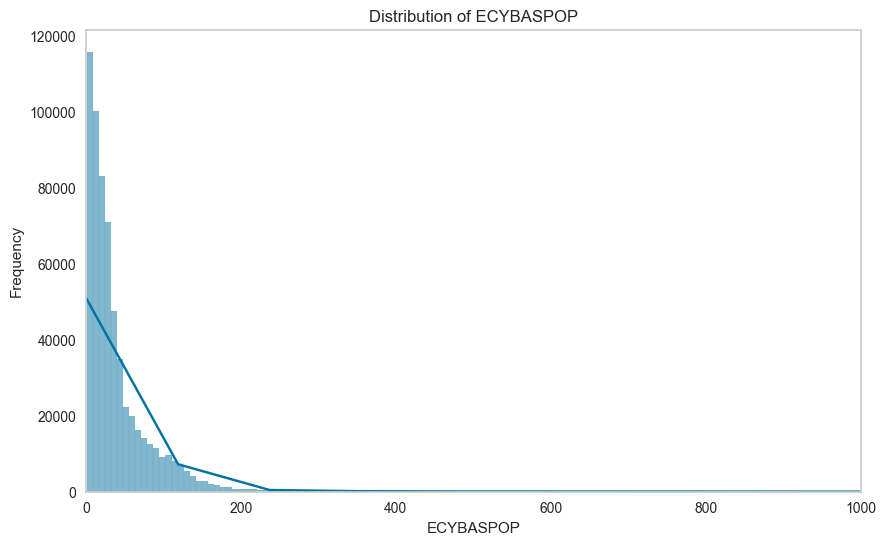

In [17]:
def plot_distribution(df, column, xlim=None, numbins=300):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=numbins, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    if xlim:
        plt.xlim(xlim)
    plt.grid()
    plt.show()

plot_distribution(merged_df_clust, "ECYBASPOP", xlim=(0, 1000), numbins=3000)

<p>You can clearly see how skewed the data is. The mean is around 40, but the median is around 20. This is a clear indication that the data is skewed to the right. We can also see that the data has a long tail that goes past 1000 (it actually goes to 20,000).</p>
<p>To fix this, we will first use a power transform to make the data more normal.</p>

In [ ]:
def apply_power_transformer(df: pl.DataFrame) -> pl.DataFrame:
    # Convert to Pandas
    df_pd = df.to_pandas()

    # Identify numeric columns
    numeric_cols = df_pd.select_dtypes(include=[np.number]).columns

    # Apply PowerTransformer to each numeric column
    transformer = PowerTransformer(standardize=False)
    df_pd[numeric_cols] = transformer.fit_transform(df_pd[numeric_cols])

    # Convert back to Polars
    return pl.from_pandas(df_pd)

cleaned_df = apply_power_transformer(merged_df_clust)

plot_distribution(cleaned_df, "ECYBASPOP", xlim=(0, 20), numbins=300)

<h3>Final Statistics</h3>

In [ ]:
print(f"Width: {cleaned_df.width}")
print(f"Height: {cleaned_df.height}")

cleaned_df.describe()

<p>We can see our data is left with 936 columns and just over 600,000 rows.</p>

<h2>Clustering</h2>
<p>We will be using the KMeans clustering algorithm to cluster the data. We will be using the elbow method, in contrast with the silhouette method to find the optimal number of clusters.</p>

<h3>Scaling</h3>
<p>Scaling will be completed using the RobustScaler, which is a scaler that is robust to outliers. This will help us to scale the data without being affected by the outliers.</p>

In [ ]:
# Define the scaler 
scaler = RobustScaler()

# Convert to Pandas DataFrame for scaling
cleaned_df = cleaned_df.to_pandas()

# Fit the scaler to the data
scaler.fit(cleaned_df)

# Transform the data
scaled_data = scaler.transform(cleaned_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_df.columns)

scaled_df.head()

<h3>Create a sample of the data</h3>
<p>We will create a sample of the data, so that we can run our clustering models faster.</p>

In [ ]:
# Sample 20% of the data
sampled_df = scaled_df.sample(frac=0.20, random_state=42)

In [ ]:

full_stats = scaled_df.mean()[:5]
sample_stats = sampled_df.mean()[:5]

print("Full Data Means:\n", full_stats)
print("\nSample Data Means:\n", sample_stats)

<h3>K-Means Clustering</h3>

<p>Create a K-Means clustering of the data, identifying the optimal number of
clusters using both the silhouette and the elbow method.</p>

<p>Start by using the elbow method to identify the optimal number of clusters.</p>

In [ ]:
# Initialize KClusterer
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)
# Use KElbowVisualizer to find optimal number of clusters
visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,16),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False # Plot the timings to train?
                             )

visualizer.fit(sampled_df)       # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<p>We can see the optimal number of clusters is 5, since the knee of the curve is at 5. This is a weak elbow, so we can confirm by using the silouette method.</p>

In [ ]:
# Silhouette Analysis
def plot_silhouette(data, n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=2025)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          alpha=0.7)
        plt.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f"Silhouette plot for {n_clusters} clusters")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# Run silhouette analysis with optimal clusters
plot_silhouette(sampled_df, 3)

<p>While the distortion elbow suggested five clusters, silhouette analysis showed that a three-cluster solution provided significantly better cohesion and separation, with an average silhouette score of ~0.23. Even though 0.23 is weak, it is still considered acceptable for high-dimensional and real-world demographic data, where perfect separation is rare. The clusters are well-balanced in size, showed no signs of singled groups. Therefore, k=3 is most likely the ideal number of clusters.</p>

<h2>Dimensionality Reduction</h2>

<h3>Apply PCA</h3>

In [ ]:
# Redefine k-clusterer with optimal number of clusters
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)

# Fit the model
cluster_labels = KClusterer.fit_predict(sampled_df)

# Apply PCA to scaled data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(sampled_df)

# Wrap into DataFrame for visualization/analysis
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["Cluster"] = cluster_labels

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=10)
plt.title("PCA Projection (PC1 vs PC2) Colored by Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Top contributing features for each component
components = pd.DataFrame(
    pca.components_, 
    columns=scaled_df.columns, 
    index=["PC1", "PC2", "PC3"]
)

for pc in components.index:
    print(f"\n{pc} top features:")
    print(components.loc[pc].abs().sort_values(ascending=False).head(5))

# Average PCA component values by cluster
avg_components_by_cluster = pca_df.groupby("Cluster")[["PC1", "PC2", "PC3"]].mean().reset_index()
print("\nAverage component values by cluster:")
print(avg_components_by_cluster)

<h3>UMAP</h3>
<p>Now we will apply UMAP to reduce the dimensionality of the data.</p>

In [ ]:
# UMAP with commonly good starting values
umap_model = umap.UMAP(n_neighbors=75,
                    n_components=2,
                    metric='cosine',
                    n_epochs=None,
                    min_dist=0.05,
                    spread=1.0,
                    low_memory=False,
                    n_jobs=-1,
                    verbose=True
                   )

umap_2d = umap_model.fit_transform(sampled_df)

# Create DataFrame
umap_df = pd.DataFrame(umap_2d, columns=["UMAP1", "UMAP2"])
umap_df["Cluster"] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", palette="tab10", s=10)
plt.title("UMAP Projection Colored by Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p>UMAP appears to perform worse than PCA. The clusters are less distinct</p>

<h1>Part 2: Regression</h1>

Now we will create models for a household’s proportion of income spent
on total personal insurance premiums and retirement/pension contributions.

Train a regularized elastic net linear regression from your data.

1. Create your target variable from the variables in the dataset. Do not use
those components on the training database.
2. Apply any data transformation / variable creation you deem necessary to
obtain a good result.
3. Discuss the grid that you chose to search for the parameters and the output
that you obtained.
4. For your test set, create a scatterplot of the original response and the
predicted response. Report the MSE and R2 on the test set and calculate a
bootstrapped confidence interval of the output.
5. Interpret the coefficients of the top five most important variables in the
regression

<h3>Splitting into Train and Test</h3>
<p>We will split the data into a training and test set. We will use 30% of the data for training and 70% for testing.</p>

In [19]:
# Split into train and test sets
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

<h3>Data Preprocessing</h3>
<p>We will be using the same preprocessing steps as before, but considering the case that we now have train and test sets</p>

In [20]:
def full_processing_pipeline(train, test):
    # Make sure Polars
    if not isinstance(train, pl.DataFrame):
        train = pl.from_pandas(train)
    if not isinstance(test, pl.DataFrame):
        test = pl.from_pandas(test)

    # Create target variable before dropping anything
    train = train.with_columns(
        (pl.col("HSEP001S") / pl.col("HSHNIAGG")).alias("Target")
    )
    test = test.with_columns(
        (pl.col("HSEP001S") / pl.col("HSHNIAGG")).alias("Target")
    )

    # === Preprocess TRAIN ===
    train = convert_na_to_nulls(train)
    train = convert_strings_to_numbers(train)
    train = remove_rows_with_nulls_or_zeros(train)
    train = substitute_nulls_with_median(train)
    train = remove_negatives(train, ["HSTT001", "HSTE001ZBS"])
    train = clean_up(train)
    train = drop_related_target_columns(train)
    train = train.drop(["HSEP001S", "HSHNIAGG"])

    train, dropped_cols = remove_perfectly_correlated_columns(train)
    train = apply_power_transformer(train)

    # === Preprocess TEST ===
    test = convert_na_to_nulls(test)
    test = convert_strings_to_numbers(test)
    test = remove_rows_with_nulls_or_zeros(test)
    test = substitute_nulls_with_median(test)
    test = remove_negatives(test, ["HSTT001", "HSTE001ZBS"])
    test = clean_up(test)
    test = drop_related_target_columns(test)
    test = test.drop(["HSEP001S", "HSHNIAGG"])
    test = test.drop([col for col in dropped_cols if col in test.columns])
    test = apply_power_transformer(test)

    # === Separate target ===
    y_train = train["Target"].to_pandas().reset_index(drop=True)
    X_train = train.drop("Target")
    y_test = test["Target"].to_pandas().reset_index(drop=True)
    X_test = test.drop("Target")

    # === Scale features ===
    scaler = RobustScaler()
    column_names = X_train.columns

    X_train = X_train.to_pandas()
    X_test = X_test.to_pandas()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train = pd.DataFrame(X_train_scaled, columns=column_names)
    X_test = pd.DataFrame(X_test_scaled, columns=column_names)

    return X_train, y_train, X_test, y_test

In [35]:
X_train, y_train, X_test, y_test = full_processing_pipeline(train, test)


# Check if the shapes of X_train and X_test are the same
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Check if the shapes of y_train and y_test are the same
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Sample 20% of the training data
sample_indices = X_train.sample(frac=0.20, random_state=2025).index

# Apply the same index to both X and y
sampled_X_train = X_train.loc[sample_indices]
sampled_y_train = y_train.loc[sample_indices]

Filling nulls in 'ECYPMAMED' with median = 40.0
Filling nulls in 'ECYPFAMED' with median = 42.5
Filling nulls in 'ECYHTAMED' with median = 41.1
Filling nulls in 'ECYHMAMED' with median = 40.0
Filling nulls in 'ECYHFAMED' with median = 42.5
Filling nulls in 'ECYMTNMED' with median = 55.0
Filling nulls in 'Target' with median = 0.05405358096908794
Removing 22 rows with negative values in 'HSTT001'
Removing 130876 rows with negative values in 'HSTE001ZBS'


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Filling nulls in 'ECYPMAMED' with median = 40.0
Filling nulls in 'ECYPFAMED' with median = 42.5
Filling nulls in 'ECYHTAMED' with median = 41.1
Filling nulls in 'ECYHMAMED' with median = 40.0
Filling nulls in 'ECYHFAMED' with median = 42.5
Filling nulls in 'ECYMTNMED' with median = 55.0
Filling nulls in 'Target' with median = 0.05405141597525884
Removing 6 rows with negative values in 'HSTT001'
Removing 32681 rows with negative values in 'HSTE001ZBS'
X_train shape: (494324, 930)
X_test shape: (123630, 930)
y_train shape: (494324,)
y_test shape: (123630,)


<h2>Elastic Net</h2>
<h3>Grid Search</h3>
<p>We will be using a grid search to find the optimal parameters for the elastic net model.</p>

In [27]:
# Set up grid search for alpha and l1_ratio
param_grid = {
    'alphas': [0.001, 0.005, 0.01],
    'l1_ratio': [0.01, 0.05, 0.1]
}

# Initialize the ElasticNetCV model
elastic_net = ElasticNetCV(
    alphas=param_grid['alphas'],
    l1_ratio=param_grid['l1_ratio'],
    cv=5,
    max_iter=20000,
    tol=1e-2,
    n_jobs=-1,
    random_state=2025
)

# Fit the model
elastic_net.fit(sampled_X_train, sampled_y_train)

print(f"Best alpha: {elastic_net.alpha_}")
print(f"Best l1_ratio: {elastic_net.l1_ratio_}")

final_model = ElasticNet(
    alpha=elastic_net.alpha_,
    l1_ratio=elastic_net.l1_ratio_,
    max_iter=20000,
    random_state=2025
)

Best alpha: 0.001
Best l1_ratio: 0.01


<h3>Model Evaluation</h3>
<p>We will be using the mean squared error and R2 score to evaluate the model. We will also be using a bootstrapped confidence interval to evaluate the model.</p>

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.227e-02
  model = cd_fast.enet_coordinate_descent(


Test Set MSE: 4.340776560317094e-05
Test Set R²: 0.8206066791975066


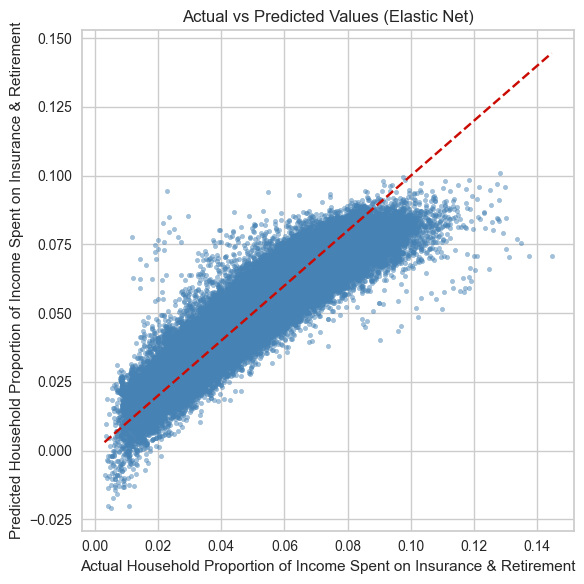

95% CI for MSE: [4.285410351095833e-05, 4.397018906742501e-05]
95% CI for R²: [0.8183431185969005, 0.8227587773586932]


In [35]:
# Fit the final model on the sampled training data
final_model.fit(X_train, y_train)

# Predict
y_pred = final_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set MSE: {mse}")
print(f"Test Set R²: {r2}")

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=10, color="steelblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Household Proportion of Income Spent on Insurance & Retirement")
plt.ylabel("Predicted Household Proportion of Income Spent on Insurance & Retirement")
plt.title("Actual vs Predicted Values (Elastic Net)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bootstrapped CI
n_bootstraps = 1000
mse_scores = []
r2_scores = []

y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_test_array), len(y_test_array), replace=True)
    mse_scores.append(mean_squared_error(y_test_array[indices], y_pred_array[indices]))
    r2_scores.append(r2_score(y_test_array[indices], y_pred_array[indices]))

mse_ci = np.percentile(mse_scores, [2.5, 97.5])
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

print(f"95% CI for MSE: [{mse_ci[0]}, {mse_ci[1]}]")
print(f"95% CI for R²: [{r2_ci[0]}, {r2_ci[1]}]")

<h3>Get and Interpret Top 5 Coefficients</h3>

In [36]:
# Get feature names and coefficients from your fitted model
feature_names = X_train.columns
coefficients = final_model.coef_

# Create a DataFrame to pair them
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Get the top 5 by absolute magnitude
top5 = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(5)

# Add interpretation column
top5['Interpretation'] = top5['Coefficient'].apply(lambda x: 
    'Positive influence (increases target)' if x > 0 else 
    'Negative influence (decreases target)' if x < 0 else 
    'No effect'
)

top5.reset_index(drop=True, inplace=True)
top5

,Feature,Coefficient,Interpretation
0,HSME001S,0.024242,Positive influence (increases target)
1,HSTX001,-0.014703,Negative influence (decreases target)
2,HSAGDISCIN,-0.011992,Negative influence (decreases target)
3,HSSH011,0.009982,Positive influence (increases target)
4,ECYHNI200P,-0.008539,Negative influence (decreases target)


<h2>XGBoost</h2>
<p>We will be using the XGBoost model to predict the target variable. We will be using the same preprocessing steps as before.</p>

In [36]:
X_train_np = sampled_X_train.to_numpy()
y_train_np = sampled_y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

<h3>Grid Search</h3>

In [41]:
# Define parameter grid
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [7, 9],
    'learning_rate': [0.1, 0.2]
}

# Initialize base model
xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=2025)

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_search.fit(X_train_np, y_train_np)

# Best model
best_xgb = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=400; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=400; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=400; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=400; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=400; total time= 4.0min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=300; total time= 7.9min
[CV] END ...learning_rate=0.1, max_depth=9, n_est

Test MSE: 2.623267754460899e-05
Test R²: 0.8915869759044996


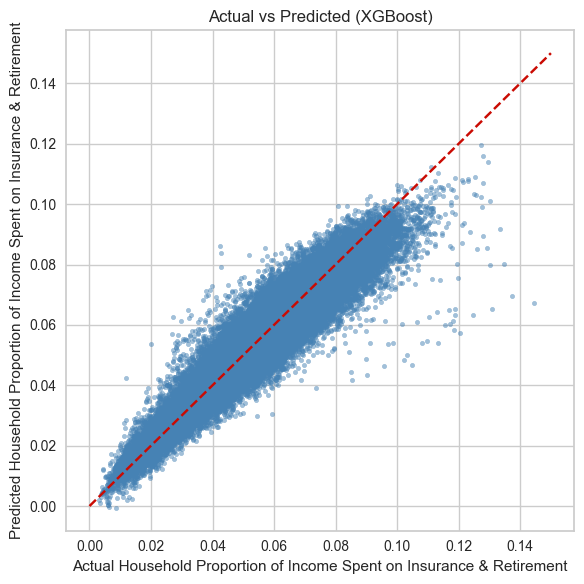

Bootstrap MSE CI: [2.58655771e-05 2.66317469e-05]
Bootstrap R² CI: [0.88985007 0.89315076]


In [42]:
# Fit the best model on the full training data
best_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = best_xgb.predict(X_test)

# Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Test MSE:", mse_xgb)
print("Test R²:", r2_xgb)

# Scatterplot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, s=10, color="steelblue")
plt.plot([0, 0.15], [0, 0.15], 'r--')
plt.xlabel("Actual Household Proportion of Income Spent on Insurance & Retirement")
plt.ylabel("Predicted Household Proportion of Income Spent on Insurance & Retirement")
plt.title("Actual vs Predicted (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

n_bootstraps = 1000
mse_scores = []
r2_scores = []

np.random.seed(42)

for _ in range(n_bootstraps):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    y_true_sample = y_test[idx]
    y_pred_sample = y_pred_xgb[idx]
    
    mse_scores.append(mean_squared_error(y_true_sample, y_pred_sample))
    r2_scores.append(r2_score(y_true_sample, y_pred_sample))

# Confidence intervals
mse_ci = np.percentile(mse_scores, [2.5, 97.5])
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

print("Bootstrap MSE CI:", mse_ci)
print("Bootstrap R² CI:", r2_ci)


<h3>Shap Explainer</h3>

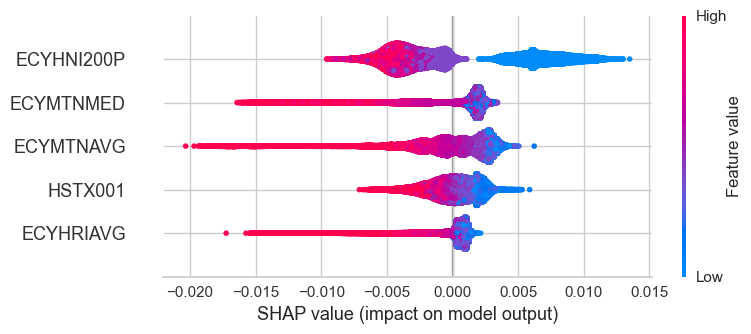

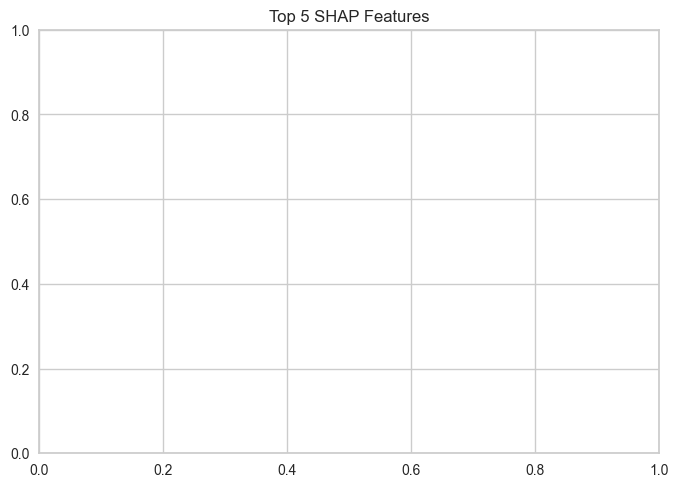

Top 5 SHAP Features & Mean SHAP Values:
ECYHNI200P: 0.00455
ECYMTNMED: 0.00277
ECYMTNAVG: 0.00233
HSTX001: 0.00144
ECYHRIAVG: 0.00132


In [49]:
# Create TreeExplainer and calculate SHAP values
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, max_display=5)
plt.title("Top 5 SHAP Features")
plt.show()

# Get mean absolute SHAP values
mean_abs_shap = shap_values.abs.mean(0)
top_5_idx = mean_abs_shap.values.argsort()[-5:][::-1]
top_5_names = X_test.columns[top_5_idx]

print("Top 5 SHAP Features & Mean SHAP Values:")
for i in range(5):
    value = mean_abs_shap.values[top_5_idx[i]]  # extract raw float
    print(f"{top_5_names[i]}: {value:.5f}")